# Exective summary of Work Package 2

## Objectives

In this WP, you will work on a given training dataset. Your goal is to develop a fault detection model using the classification algorithms learnt in the class, in order to achieve best F1 score.

## Tasks

- Task 1: Develop a fault detection model using the unsupervised learning algorithms learnt in the class, in order to achieve best F1 score.
- Task 2: With the help of the supporting script, develop a cross-validation scheme to test the performance of the developed classification algorithms.
- Task 3: Develop a fault detection model using the classification algorithms learnt in the class, in order to achieve best F1 score.

## Delierables

- A Jupyter notebook reporting the process and results of the above tasks


# Before starting, please:
- Fetch the most up-to-date version of the github repository.
- Create a new branch with your name, based on the "main" branch and switch to your own branch.
- Copy this notebook to the work space of your group, and rename it to TD_WP_2_Your name.ipynb
- After finishing this task, push your changes to the github repository of your group.

# Task 1: Unsupervised learning approaches

## Implement the statistical testing approach for fault detection

In this exercise, we interpret the statistical testing approach for fault detection. The basic idea of statistical testing approach is that we fit a multi-dimensitional distribution to the observation data under normal working condition. Then, when a new data point arrives, we design a hypothesis test to see whether the new data point is consistent with the distribution. If the new data point is consistent with the distribution, we can conclude that the fault is not due to the faulty component.

The benefit of this approach is that, to design the detection algrothim, we do not need failed data. Also, the computational time is short as all we need is just to compute the pdf and compare it to a threshold.

In this exercise, you need to:
- Fit a multi-dimensitional distribution to the training dataset (all normal samples).
- Design a fault detection algorithm based on the fitted distribution to detect faulty components.

The following block defines a few functions that you can use.

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
from scipy.stats import multivariate_normal


def estimateGaussian(X):
    '''Given X, this function estimates the parameter of a multivariate Gaussian distribution.'''
    mu = np.mean(X, axis=0)
    sigma2 = np.var(X, axis=0)
    return mu, sigma2


def classify(X, distribution, log_epsilon):
    '''Given X, this function classifies each sample in X based on the multivariate Gaussian distribution. 
       The decision rule is: if the log pdf is less than log_epsilon, we predict 1, as the sample is unlikely to be from the distribution, which represents normal operation.
    '''
    p = distribution.logpdf(X)
    predictions = (p < log_epsilon).astype(int)
    
    return predictions


Let us use the dataset `20240105_164214` as training dataset, as all the samples in this dataset are normal operation. We will use the dataset `20240325_155003` as testing dataset. Let us try to predict the state of motor 1. For this, we first extract the position, temperature and voltage of motor 1 as features (you can change the features if you want). 

In [37]:
import sys
sys.path.insert(0, 'C:/Users/gioca/GitHub/Group_6/projects/maintenance_industry_4_2024/supporting_scripts/WP_1')

from utility import read_all_csvs_one_test
import pandas as pd

# Specify path to the dictionary.
base_dictionary = 'C:/Users/gioca/GitHub/Group_6/projects/maintenance_industry_4_2024/dataset/training_data/'
dictionary_name = '20240105_164214'
path = base_dictionary + dictionary_name

# Read the data.
df_data = read_all_csvs_one_test(path, dictionary_name)

# Get the features
X_train = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]

# We do the same to get the test dataset.
dictionary_name = '20240325_155003'
path = base_dictionary + dictionary_name

# Read the data.
df_data = read_all_csvs_one_test(path, dictionary_name)

# Get the features
X_test = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
y_test = df_data['data_motor_1_label']

Please design your algorithm below:

In [3]:
# First, we need to fit a MVN distribution to the normal samples.
# Put your code here.

from sklearn.metrics import accuracy_score

mu, sigma2 = estimateGaussian(X_train)

# Construct a multivariate Gaussian distribution to represent normal operation.
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))

# Now, let's try to predict the labels of the test set X_test.
# Put your code here.

y_pred = classify(X_test, distribution, -50)

# Calculate accuracy of the prediction.
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# In this block of code we simply used the functions pre-defined to predict the label of the test dataset, without any attempt of improving the results.

Accuracy: 0.19422730006013228


**Discussions:**
- Can you please try to improve the performance of this approach?
    - For example, by normalizating the data?
    - By smoothing the data?
    - By reducing feature number?
    - etc.
- The parameter log_epsilon defines the threshold we use for making classification. What happens if you change it?
- Could you discuss how we should get the best value for this parameter?

Accuracy: 0.19422730006013228
Accuracy: 0.19422730006013228
Accuracy: 0.19422730006013228
('data_motor_1_position',)
The maximum accuracy is 0.9158147925435959


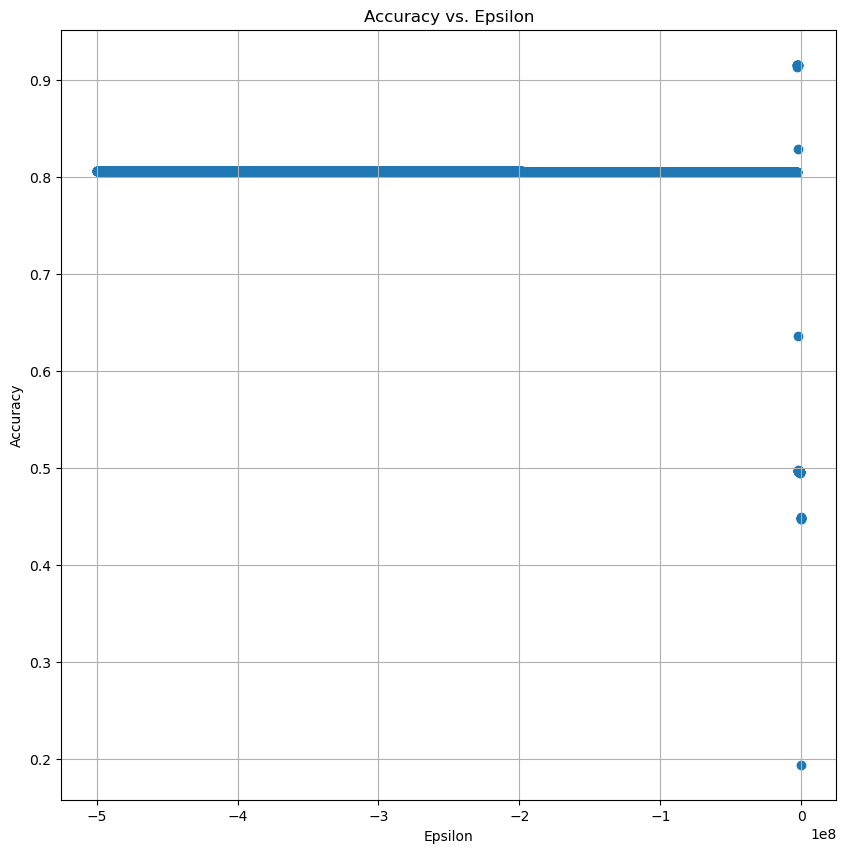

('data_motor_1_temperature',)
The maximum accuracy is 0.8057726999398677


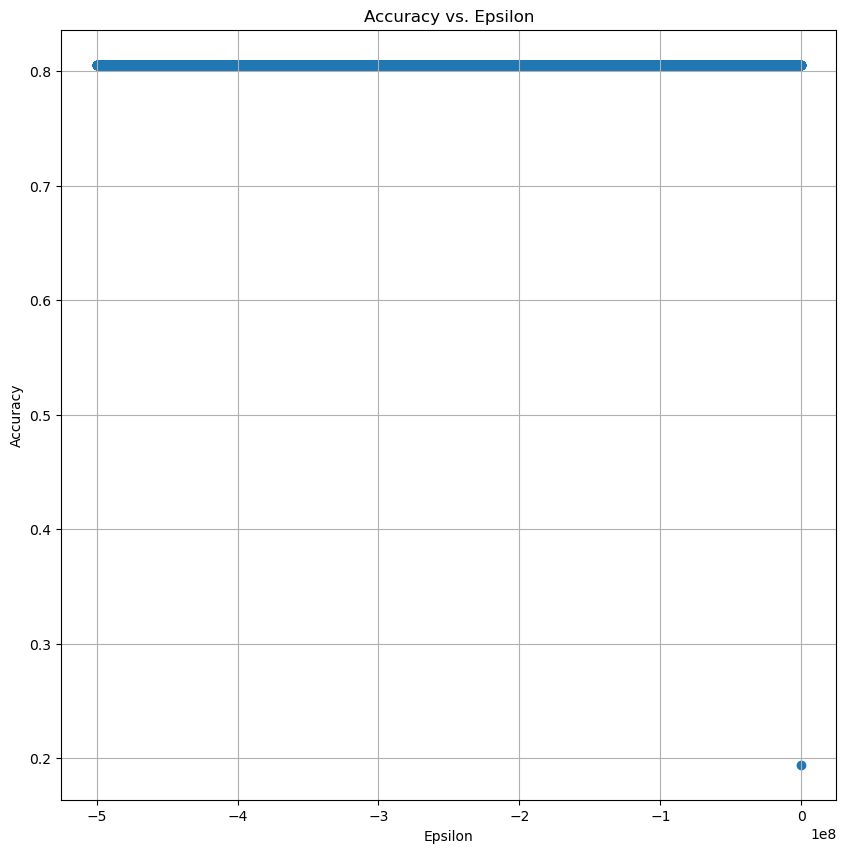

('data_motor_1_voltage',)
The maximum accuracy is 0.8205051112447385


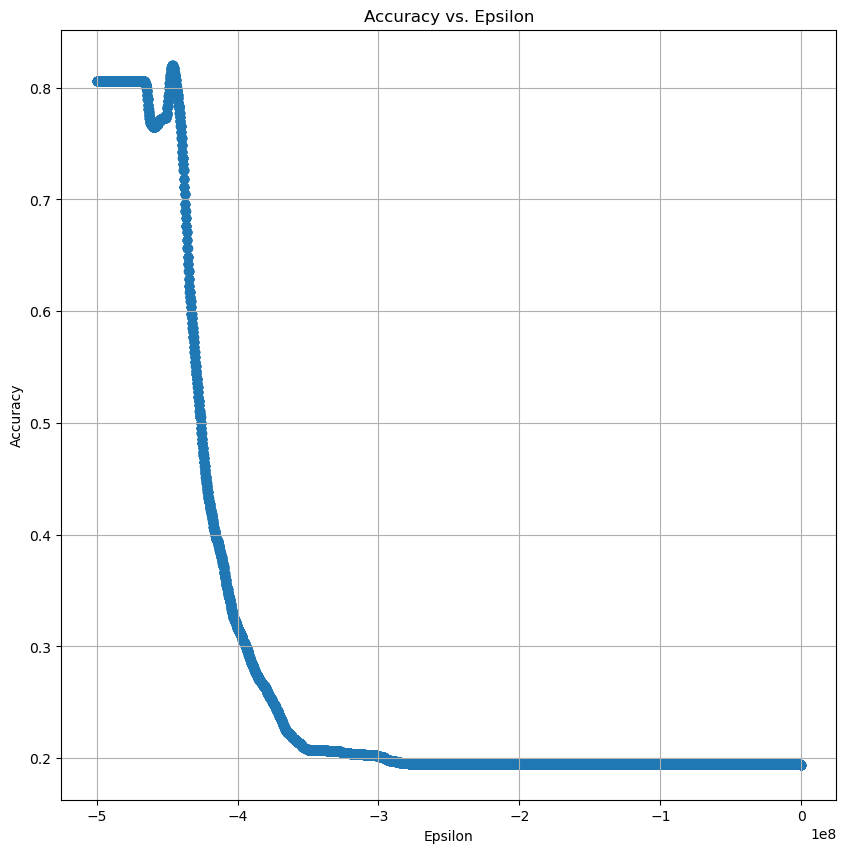

('data_motor_1_position', 'data_motor_1_temperature')
The maximum accuracy is 0.9158147925435959


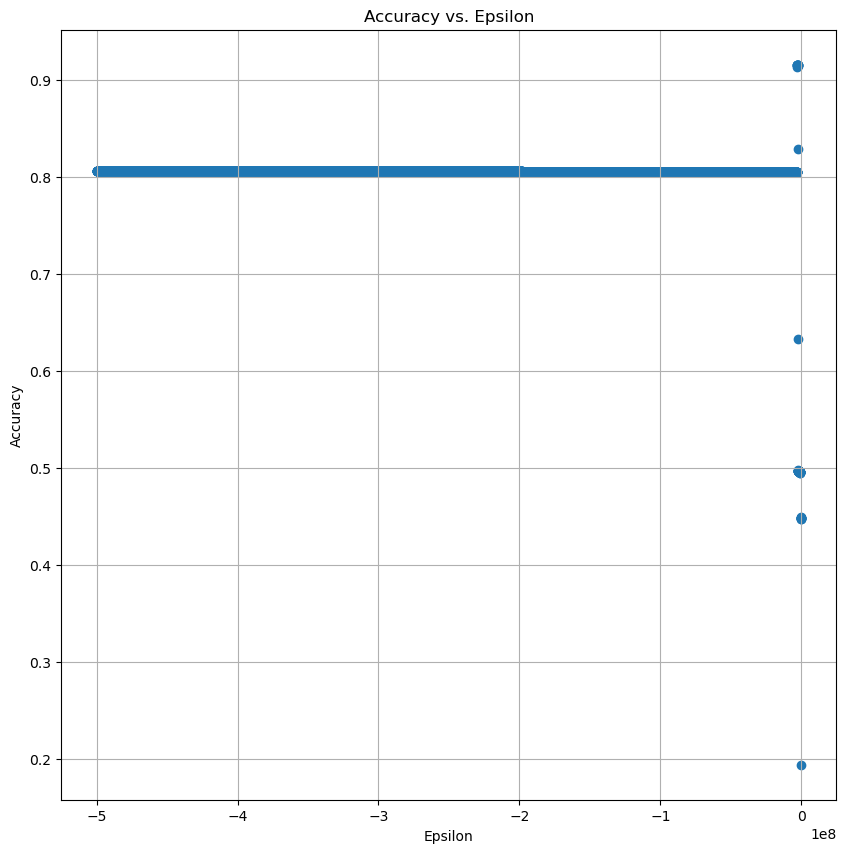

('data_motor_1_position', 'data_motor_1_voltage')
The maximum accuracy is 0.8287733012627782


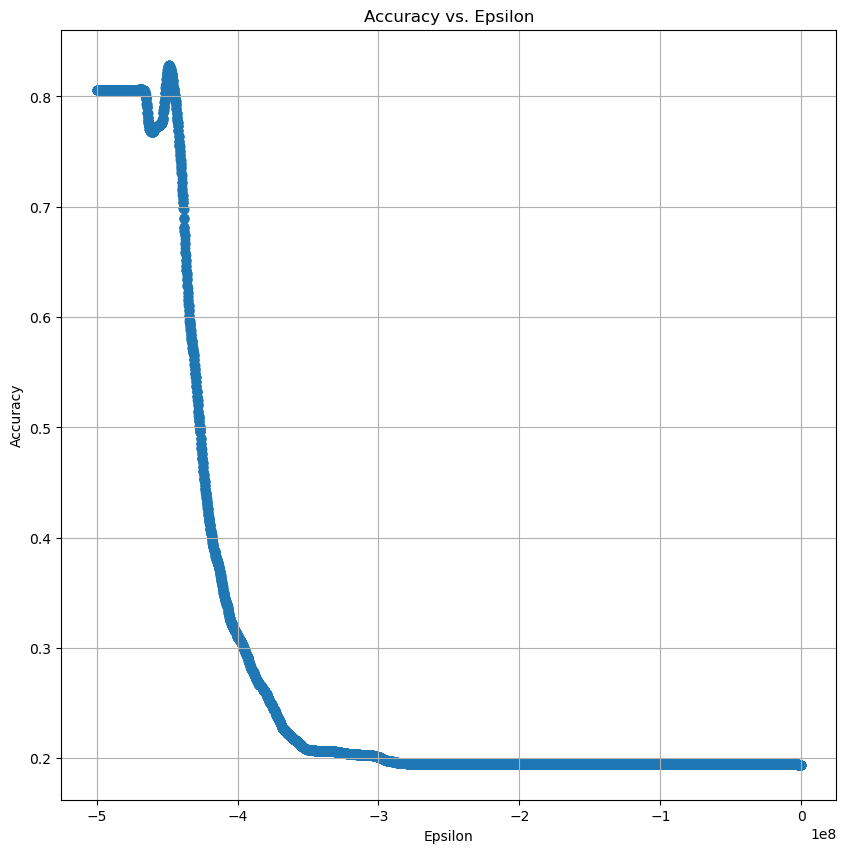

('data_motor_1_temperature', 'data_motor_1_voltage')
The maximum accuracy is 0.8205051112447385


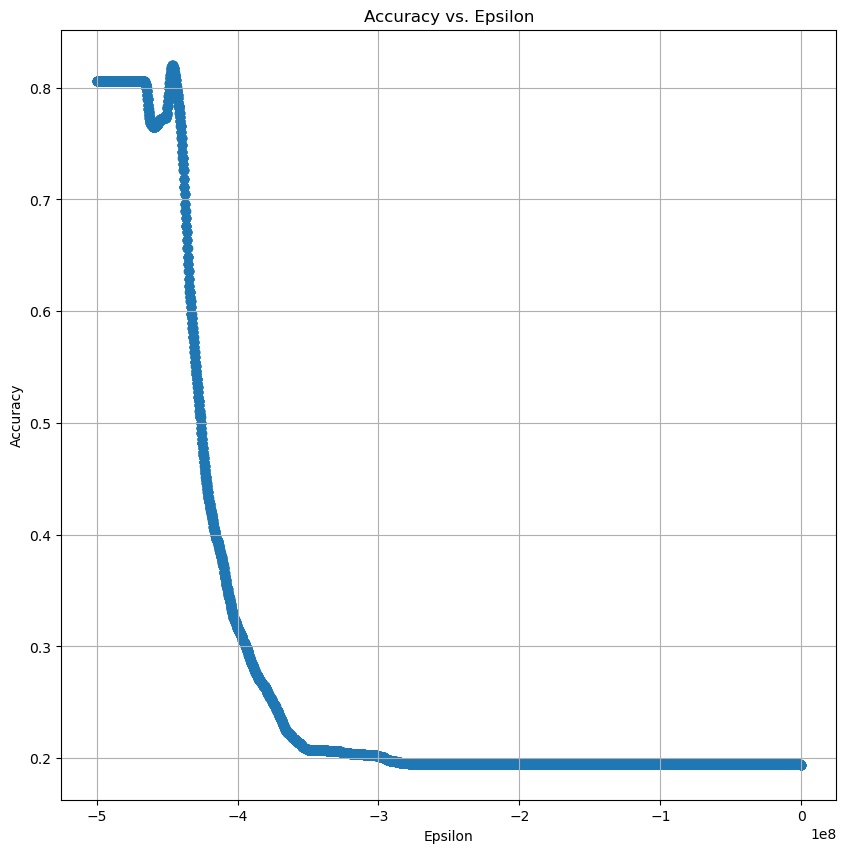

('data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage')
The maximum accuracy is 0.8287733012627782


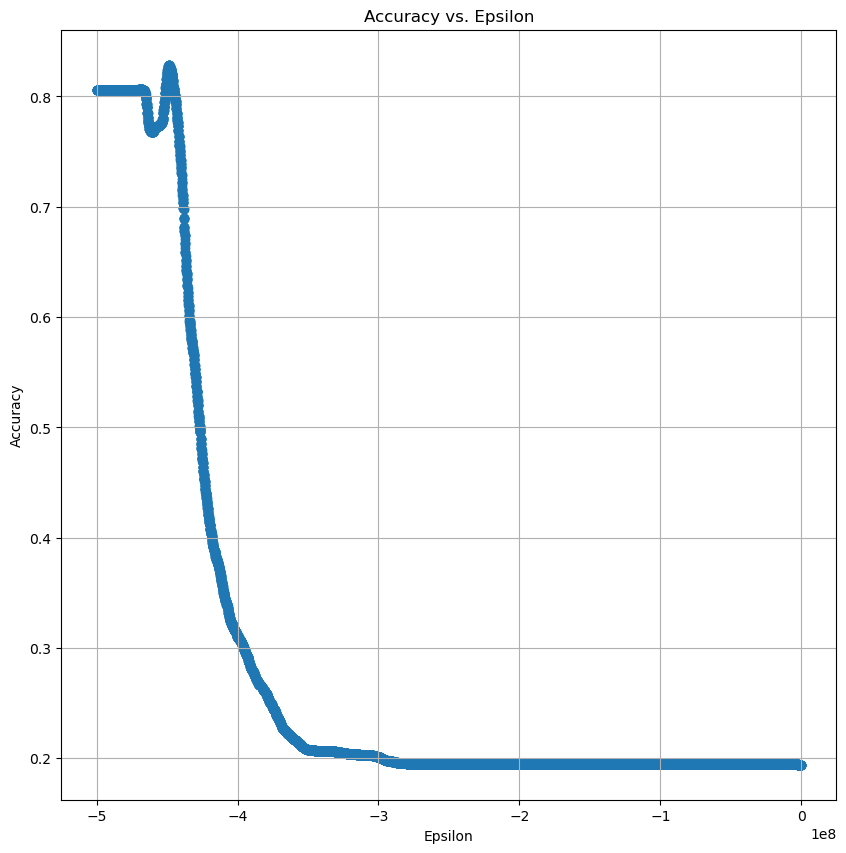

In [13]:
# Initially, we don't want to modify the value of epsilon, in order to understand if each of the changes we make directly impact the precision of the model.

# First of all, we eliminate the outliers.

from numpy import quantile, where, random
import pandas as pd
from sklearn.neighbors import LocalOutlierFactor
from itertools import combinations

X_train_copy = X_train.copy()
X_train_copy['indice'] = X_train.reset_index().index
model = LocalOutlierFactor(n_neighbors=20)

def removeoutliers (feature):

    x = pd.DataFrame(X_train_copy, columns=['indice',feature])
    model.fit_predict(x)
    lof = model.negative_outlier_factor_ 
    df_out = pd.DataFrame({'indice': x['indice'], 'lof': lof })

    return df_out

features = ['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']
for j in features:
     outliers = removeoutliers(j)
     thresh1 = np.quantile(outliers.lof, 1/3000)
     index = where(outliers.lof<=thresh1)
     final_index = np.ravel(outliers['indice'].iloc[0] + index)
     X_train_copy = X_train_copy[~X_train_copy['indice'].isin(final_index)]

X_train_copy = X_train_copy.drop(columns='indice')

mu, sigma2 = estimateGaussian(X_train_copy)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
y_pred = classify(X_test, distribution, -50)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# This first change didn't affect the result of the accuracy. At this point, the second step is to standardize the data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_copy = pd.DataFrame(scaler.fit_transform(X_train_copy), columns=X_train_copy.columns, index=X_train_copy.index)
mu, sigma2 = estimateGaussian(X_train_copy)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
y_pred = classify(X_test, distribution, -50)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# The standardization doesn't affect at all the accuracy of the prediction. At this point, we tried to smooth the data.

for i in features:
     X_train_copy[i] = X_train_copy[i].rolling(window=25, center=True).mean()
X_train_copy = X_train_copy.dropna(axis=0)
mu, sigma2 = estimateGaussian(X_train_copy)
distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
y_pred = classify(X_test, distribution, -50)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# The smoothing didn't affect at all the accuracy of the prediction. At this point, we tested the impact of the different combinations of features.

all_combinations = []
for r in [1, 2, 3]:
    combinations_of_covariates = list(combinations(features, r))
    all_combinations.extend(combinations_of_covariates)

for combo in all_combinations:
     covariates = list(combo)
     X_prova = X_train_copy[covariates]

     epsilon_values = np.linspace(-500000000, 1000, num=10000)
     accuracy_results = []
     epsilon_list = []
     for epsilon in epsilon_values:
         mu, sigma2 = estimateGaussian(X_prova)
         distribution = multivariate_normal(mean=mu, cov=np.diag(sigma2))
         y_pred = classify(X_test[covariates], distribution, epsilon)
         accuracy = accuracy_score(y_test, y_pred)
         accuracy_results.append(accuracy)
         epsilon_list.append(epsilon)

     print(combo)  
     max_accuracy = np.max(accuracy_results)  
     print(f"The maximum accuracy is {max_accuracy}")
     plt.figure(figsize=(10, 10))
     plt.scatter(epsilon_list, accuracy_results)
     plt.xlabel('Epsilon')
     plt.ylabel('Accuracy')
     plt.title('Accuracy vs. Epsilon')
     plt.grid(True)
     plt.show()


# It looks like the accuracy doesn't depend on the number of features, which is actually very strange.
# Therefore, we tried to vary the value of epsilon in order to understand which is the optimal one. To do this, we plotted the value of accuracy depending on epsilon.

# It's visible that, changing the value of epsilon, the accuracy changes a lot. Anyway, identifying the correct value of epsilon may be very difficult, since they vary a lot.

## Local outiler factor (LOF)

The local outlier factor (LOF) algorithm computes the local density deviation of a given data point with respect to its neighbors. It considers as outliers the samples that have a substantially lower density than their neighbors. You can easiliy implement LOF in scikit-learn ([tutorial](https://www.datatechnotes.com/2020/04/anomaly-detection-with-local-outlier-factor-in-python.html)).

Please implement local outlier factor (LOF) algorithm on the dataset of `20240325_155003`. You can try first to detect the failure of motor 1 using this model. Please calculate the accuracy score of your prediction.

-1.9177531264299676


InvalidIndexError: (array([ 529,  559,  572,  614,  618,  633,  634,  635,  642,  646,  647,
        650,  651,  654,  656,  664,  734,  751,  782,  810,  815,  825,
        861,  862,  865,  866,  867,  868,  869,  870,  876,  882,  897,
        904,  905,  914,  915,  919,  926,  936,  937,  964,  966,  975,
        977,  978,  979,  984,  991,  995,  997,  998, 1000, 1001, 1007,
       1020, 1055, 1065, 1111, 1311, 1766, 1916, 1917, 1918, 1919, 1920,
       1921, 1922, 1923, 1924, 1925, 1926, 1927, 1928, 1929, 1930, 1931,
       1932, 1939, 1941, 2073, 2131, 2192, 2209, 2210, 2301, 2305, 2311,
       2332, 2333, 2359, 2598, 3018, 3407, 3408, 3422, 3648, 3655, 3658,
       3703, 3836, 4138, 4139, 4140, 4141, 4143, 4144, 4145, 4146, 4147,
       4148, 4149, 4150, 4151, 4152, 4153, 4157, 4163, 4164, 4165, 4167,
       4172, 4173, 4177, 4182, 4186, 4193, 4203, 4206, 4207, 4214, 4216,
       4273, 4603, 4613, 4616, 4626, 4631, 4664, 4665, 4692, 4694, 4751,
       4898, 4901, 4908, 4911, 4991, 5009, 5015, 5085, 5109, 5136, 5139,
       5321, 5630, 5673, 5762, 5763, 5764, 5765, 5766, 5767, 5768, 5814,
       5826, 5830, 5836, 5841, 5843, 5857, 5860, 5868, 5873, 5874, 5875,
       5882, 5889, 5946, 5955, 6084, 6128, 6215, 6266, 6345, 6346, 6347,
       6348, 6368, 6369, 6373, 6374, 6377, 6378, 6381, 6397, 6415, 6455,
       6464, 6551], dtype=int64), slice(None, None, None))

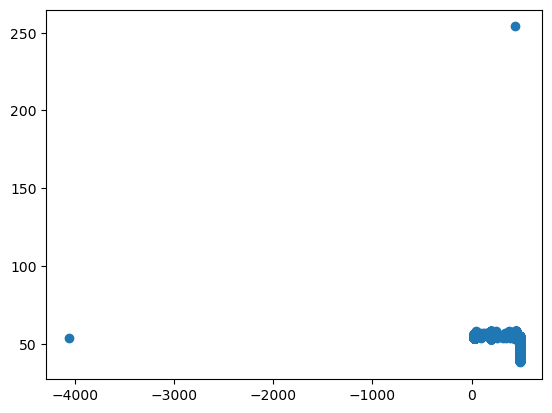

In [47]:
from sklearn.neighbors import LocalOutlierFactor
from numpy import quantile, where


y_test = pd.DataFrame(y_test, columns=['data_motor_1_label'])

X_test_copy = X_test.copy()
model = LocalOutlierFactor(n_neighbors=20) 
model.fit_predict(X_test_copy)
lof = model.negative_outlier_factor_ 
thresh = quantile(lof, .03)
print(thresh)
index = where(lof<=thresh)
index_array = index[0]
y_test['indice'] = y_test.index
values = y_test.loc[index_array, 'data_motor_1_label']


# Crea uno scatter plot per X_test_copy
plt.scatter(X_test_copy.iloc[:, 0], X_test_copy.iloc[:, 1], label='Dati normali')
outlier_points = X_test_copy[index_array, :]
plt.scatter(outlier_points.iloc[:, 0], outlier_points.iloc[:, 1], color='red', label='Outlier')
plt.show()



# Task 2 Develop a cross validation pipeline to evaluate the performance of the model.

The idea of cross validation is to split the data into k subsets and use one of them as the test set and the rest as the training set. The performance of the model is evaluated only on the test dataset, while the model is trained on the training dataset. By doing this, we ensure that the evaluation of the model is independent from the training of the model. Therefore, we can detect if the model is overfitted.

## k-fold cross validation

Here, we use motor 1 as an example to develop a pipeline for cross validation. Below, you have a script that read the data, extract features and get the labels.

1. Use sk-learn to split the data into training and testing sets, using a k-fold cross validation with k=5. (Hint: This is a routine task which can be answered easily by language models like chatgpt. You can try prompt like this: `Generate a code in python to split the data X and y into training and testing sets, using a k-fold cross validation with k=5.`)
2. Then, train a basic logistic regression model, without hyper-parameter tuning on the training set, and use the testing set to evaluate the performance of the model (calculate accuracy, precision, recall, and F1 score). 
3. Finally, train a logistic regression model, but use the entire dataset X and y as training data. Then, use the trained model to predict the labels of the same dataset (X). Compare the results with the previous step, and discuss why we should use cross validation to evaluate the performance of the model.

In [ ]:
import sys
sys.path.insert(0, 'C:/Users/Zhiguo/OneDrive - CentraleSupelec/Code/Python/digital_twin_robot/projects/maintenance_industry_4_2024/supporting_scripts/WP_1')

from utility import read_all_csvs_one_test
import pandas as pd

# Specify path to the dictionary.
# Define the path to the folder 'collected_data'
base_dictionary = '../../dataset/training_data/'
# Read all the data
df_data = read_all_test_data_from_path(base_dictionary)

# Extract the features for motor 1: You should replace the features with the ones you have selected in WP1.
X = df_data[['data_motor_1_position', 'data_motor_1_temperature', 'data_motor_1_voltage']]
# Get the label
y = df_data['data_motor_1_label']


Write your discussions here:


# Task 3: Develop classification-based fault detection models

In this task, you are supposed to experiment different classification-based fault detection models to get best F1 score. Please use the 5-fold cross-validation to calculate the best F1 score. You are free to try different models, whether they are discussed in the class or not. To simply your work, you can use the models existed in [scikit-learn](https://scikit-learn.org/stable/supervised_learning.html).

Please report all the models you tried, how to you tune their hyperparameters, and the corresponding F1 score. Please note that if you would like to tune the hyperparameter, you can use the `GridSearchCv` function in scikit-learn, but you should use it only on the training dataset.

## Logistic regression

In [ ]:
# Your code here:

## Summary of the results

Please add a table in the end, summarying the results from all the models (including the unsupervised learning models). Please write a few texts to explain what is the best model you got, its performance, and how could you further improve it.

| Model   | Accuracy | Precision | Recall | F1   |
|---------|----------|-----------|--------|------|
| Model 1 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 2 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
| Model 3 |   XX.X%  |   XX.X%   |  XX.X% | XX.X%|
